<a href="https://colab.research.google.com/github/shrikant-temburwar/Face-mask-detection/blob/master/face_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face mask detection in images with OpenCV

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from google.colab.patches import cv2_imshow

### Initialize the initial learning rate, number of epochs to train for and batch size

In [0]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

### Load data


In [11]:
print("loading images...")
imagePaths = list(paths.list_images('/content/data'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

loading images...


### Perform one-hot encoding on the labels


In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify = labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range= 20,
	zoom_range= 0.15,
	width_shift_range= 0.2,
	height_shift_range= 0.2,
	shear_range= 0.15,
	horizontal_flip= True,
	fill_mode= "nearest")

### Load the MobileNetV2 network, ensuring the head FC layer sets are  left off


In [14]:
baseModel = MobileNetV2(weights= "imagenet", include_top= False, input_tensor= Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size= (7, 7))(headModel)
headModel = Flatten(name= "flatten")(headModel)
headModel = Dense(128, activation= "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation= "softmax")(headModel)
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs= baseModel.input, outputs= headModel)
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Compile our model


In [15]:
print("compiling model...")
opt = Adam(lr= INIT_LR, decay= INIT_LR / EPOCHS)
model.compile(loss= "binary_crossentropy", optimizer= opt, metrics= ["accuracy"])

# train the head of the network
print("training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size= BS),
	steps_per_epoch= len(trainX) // BS,
	validation_data= (testX, testY),
	validation_steps= len(testX) // BS,
	epochs= EPOCHS)

compiling model...
training head...
Epoch 1/20
34/34 [==============================] - 15s 448ms/step - loss: 0.4018 - accuracy: 0.8090 - val_loss: 0.0734 - val_accuracy: 0.9891
Epoch 2/20
34/34 [==============================] - 13s 390ms/step - loss: 0.1206 - accuracy: 0.9597 - val_loss: 0.0363 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 13s 391ms/step - loss: 0.0733 - accuracy: 0.9785 - val_loss: 0.0255 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 13s 397ms/step - loss: 0.0516 - accuracy: 0.9869 - val_loss: 0.0203 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 13s 390ms/step - loss: 0.0402 - accuracy: 0.9888 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 13s 390ms/step - loss: 0.0479 - accuracy: 0.9841 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 13s 393ms/step - loss: 0.0334 - accuracy: 0.9878 - val

### Make predictions on the testing set


In [26]:
print("evaluating network...")
predIdxs = model.predict(testX, batch_size= BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis= 1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis= 1), predIdxs, target_names=lb.classes_))
# serialize the model to disk
#print("saving mask detector model...")
model.save("/content/model.h5", save_format= "h5")

evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



### Plot the training loss and accuracy


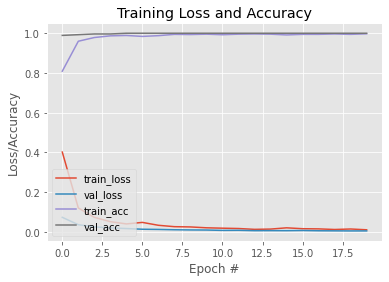

In [48]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Detecting mask image

In [53]:
# load our serialized face detector model from disk
print("loading face detector model...")
prototxtPath = os.path.sep.join(['/content/face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['/content/face_detector', "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# # load the face mask detector model from disk
print("loading face mask detector model...")
model = load_model('/content/model.h5')

loading face detector model...
loading face mask detector model...


In [0]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
def detect_mask(path):
    image = cv2.imread(path)
    orig = image.copy()
    (h, w) = image.shape[:2]
    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    net.setInput(blob)
    detections = net.forward()
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, withoutMask) = model.predict(face)[0]
            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    # show the output image
    cv2_imshow(image)

[INFO] computing face detections...


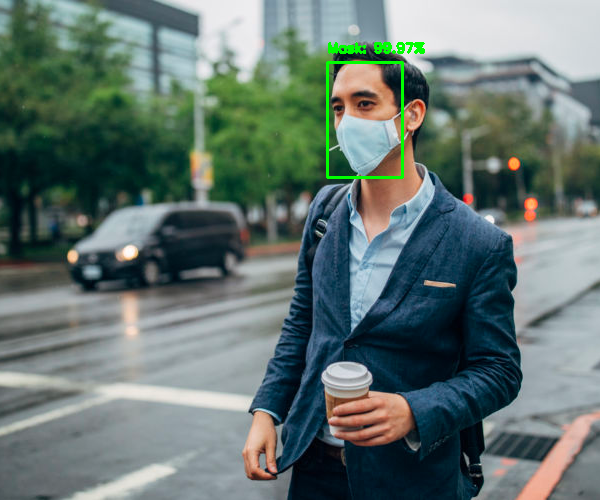

In [63]:
detect('/content/example_01.png')

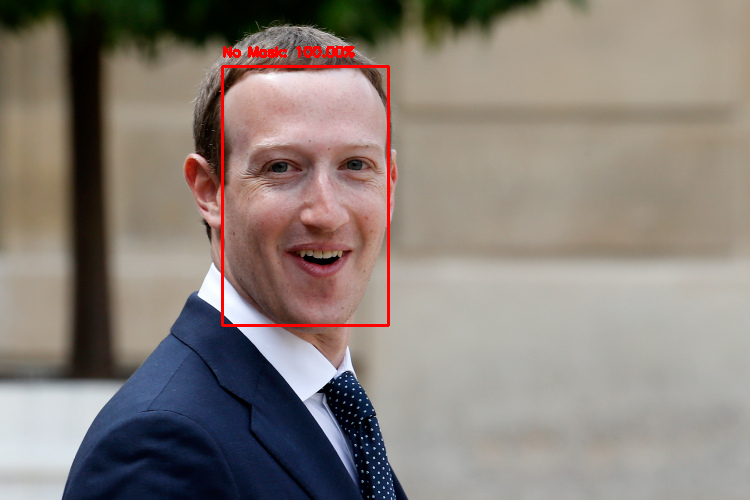

In [64]:
detect_mask('/content/example_03.jpg')